In [33]:
import elevation_grid as eg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import geopandas 


import sys
import datetime
assert sys.version_info >= (3, 5) # make sure we have Python 3.5+

from pyspark.sql import SparkSession, functions, types
spark = SparkSession.builder.appName('weather_tomorrow').getOrCreate()
assert spark.version >= '2.3' # make sure we have Spark 2.3+
spark.sparkContext.setLogLevel('WARN')

from pyspark.ml import PipelineModel
from pyspark.ml.evaluation import RegressionEvaluator

In [34]:
model = PipelineModel.load('./weather-model_retrain')

In [35]:
tmax_schema = types.StructType([
        types.StructField('station', types.StringType()),
        types.StructField('date', types.DateType()),
        types.StructField('latitude', types.FloatType()),
        types.StructField('longitude', types.FloatType()),
        types.StructField('elevation', types.FloatType()),
        types.StructField('tmax', types.FloatType()),
    ])

data = spark.read.csv('./tmax-test', schema=tmax_schema)


In [76]:
prediction = model.transform(data)

In [83]:
# set the configuration for arrwo
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# convert the spark df to pandas df so that we can plot
prediction_pd = prediction.select("*").toPandas()

In [84]:
prediction_pd['absolute_error'] = abs(prediction_pd['tmax']-prediction_pd['prediction'])

In [85]:
prediction_pd = prediction_pd.groupby(['station','date']).agg('mean')


In [88]:
prediction_pd = prediction_pd.groupby('station').agg('mean')

In [90]:
prediction_pd = prediction_pd[['latitude', 'longitude', 'absolute_error']]

In [91]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.GeoDataFrame(prediction_pd, geometry=gpd.points_from_xy(prediction_pd.longitude, prediction_pd.latitude))



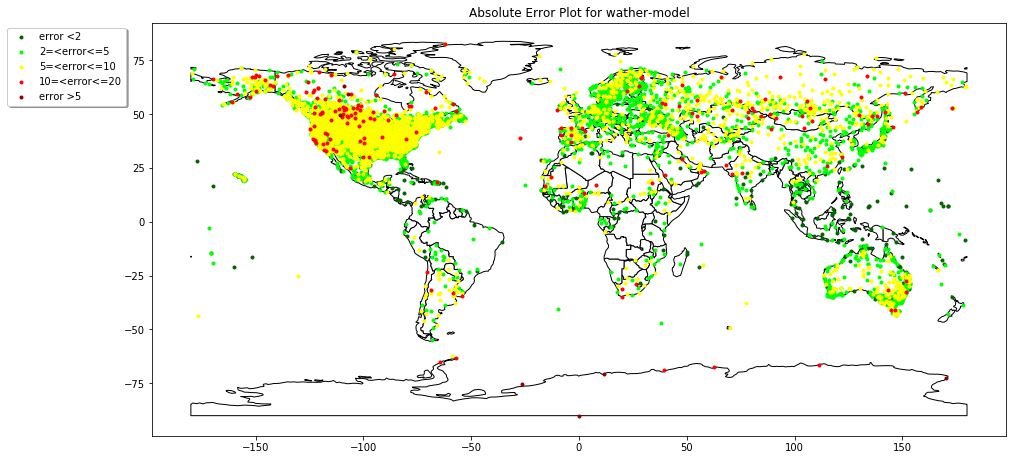

In [94]:
fig, ax = plt.subplots(figsize=(17,10))
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax, color='white', edgecolor='black')
gdf[gdf['absolute_error']<2].plot(ax=ax,color='darkgreen',label='error <2',marker='.')
gdf[(gdf['absolute_error']>=2) & (gdf['absolute_error']<=5) ].plot(ax=ax,color='lime',label='2=<error<=5',marker='.')
gdf[(gdf['absolute_error']>=5) & (gdf['absolute_error']<=10) ].plot(ax=ax,color='yellow',label='5=<error<=10',marker='.')
gdf[(gdf['absolute_error']>=10) & (gdf['absolute_error']<=20) ].plot(ax=ax,color='red',label='10=<error<=20',marker='.')
gdf[gdf['absolute_error']>20].plot(ax=ax,color='darkred',label='error >5',marker='.')
chartBox = ax.get_position()
ax.set_position([chartBox.x0, chartBox.y0, chartBox.width*0.9, chartBox.height])
ax.legend(loc='upper center', bbox_to_anchor=(-0.1, 1), shadow=True, ncol=1)
plt.title('Absolute Error Plot for wather-model')
plt.show()


